In [121]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer, StandardScaler, Binarizer, OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPRegressor
import datetime
import re

In [2]:
# pip install xlrd

In [2]:
data = pd.read_excel('regression_data.xls')

In [3]:
data.head() 

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  7129300520 2014-10-13         3       1.00         1180      5650     1.0   
1  6414100192 2014-12-09         3       2.25         2570      7242     2.0   
2  5631500400 2015-02-25         2       1.00          770     10000     1.0   
3  2487200875 2014-12-09         4       3.00         1960      5000     1.0   
4  1954400510 2015-02-18         3       2.00         1680      8080     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      7        2170            400      1951   
2           0     0          3      6         770              0      1933   
3           0     0          5      7        1050            910      1965   
4           0     0          3      8        1680              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15   price  
0             0    98178  47.5112 -122.257           1340        5650  221900  
1          1991    98125  47.7210 -122.319           1690        7639  538000  
2             0    98028  47.7379 -122.233           2720        8062  180000  
3             0    98136  47.5208 -122.393           1360        5000  604000  
4             0    98074  47.6168 -122.045           1800        7503  510000

In [4]:
data.dtypes

id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object

- price = target. 
- Columns to consider dropping: ID, lat & long, sqft_living, sqft_lot (opt for 15 instead)
- observation: the features are all discreet numerical values
- extract year from date and drop.


In [5]:
data.info() # checking shape (21597 x 21), dtypes and for nulls (no NAs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [6]:
data = data.drop(['id','lat','long'],axis=1)

In [7]:
data['year_sold'] = data['date'].dt.year

In [8]:
data['year_sold'].value_counts()

2014    14622
2015     6975
Name: year_sold, dtype: int64

In [10]:
data = data.drop(['date'],axis=1)

KeyError: "['date'] not found in axis"

In [11]:
numericals = data.drop(['bedrooms','bathrooms','floors','waterfront','view','condition','grade','yr_renovated','zipcode','year_sold', 'yr_built'],axis=1)

In [12]:
categoricals = data.drop(['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15','price'],axis=1)

In [13]:
re.findall('sqft_\w*',str(data.columns))

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

In [22]:
# categoricals = data.drop([(re.findall('sqft_\w*',str(data.columns))),'price'],axis=1)

In [14]:
data.shape

(21597, 18)

In [15]:
print('numericals')
print(numericals.shape)
print(numericals.columns)
print('\n')
print('categoricals')
print(categoricals.shape)
print(categoricals.columns)

numericals
(21597, 7)
Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')


categoricals
(21597, 11)
Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'zipcode', 'year_sold'],
      dtype='object')


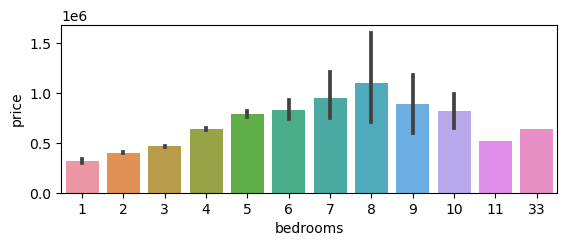

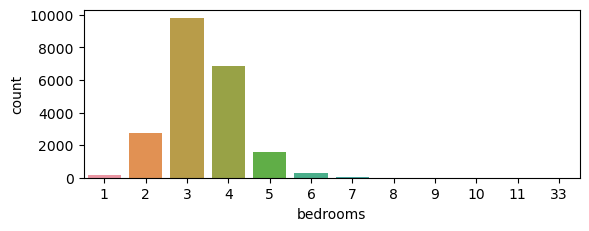

In [39]:
# plt.figure
# plt.subplot(2,1,1)
# sns.barplot(y=data['price'],x='bedrooms', data=categoricals)
# plt.show()
# plt.subplot(2,1,2)
# sns.countplot(x='bedrooms',data=categoricals)
# plt.show()

exploring categorical columns
notes:
- houses with more bathrooms sell for higher price (direct relationship)
--> maybe combine the two columns to see how many groups are created, first simplify bathrooms
--> OR bedrooms: create groupings of '1-3' & '4+' 
--> bathrooms:  create new column for the partial bath rooms, then group by number of bathrooms 
- 'view' group in to 0 and 1+
--> or combine 'view' and 'waterfront'
--> all waterfront houses had view of 2 or greater (except 1).
--> drop 'waterfront'
- for 'floor', remove the .5 and create new binary column for 'attic'. .5 = YES 
- 'yr_renovated' convert to binary (Y/N) column 'renovated'. Then drop 'yr_renovated'
- 'yr_built' group by decade or quarter-century or millenium (binary). 1900-2014
--> used pd.cut and pd.qcut (each with parm 4) and compared using barplot vs 'price'
--> obervation: older homes (pre-1950) and newer homes (after 1997) are more valuable. 
- data from 'zipcode' does not impact the data, considering dropping. 
- 'condition' vs 'grade'
--> grouped condition into 1-7 and 8+

numerical columns
notes:
- sq_basement is better as an indicator as to whether the house has a basement or not as its sq_ft is included in the difference between the above & living sq_ft

Column Name:  bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


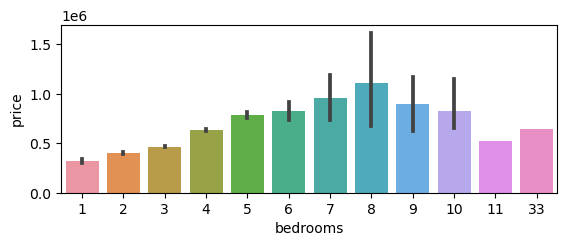

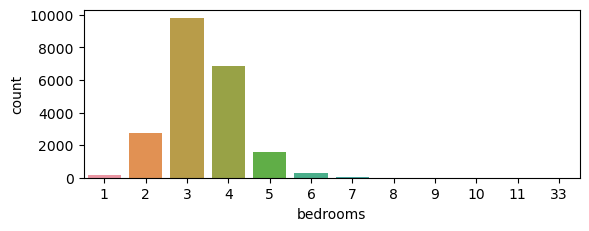

Column Name:  bathrooms
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64


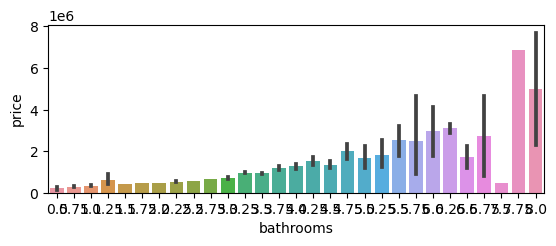

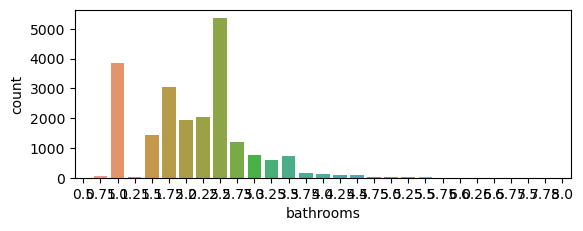

Column Name:  floors
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64


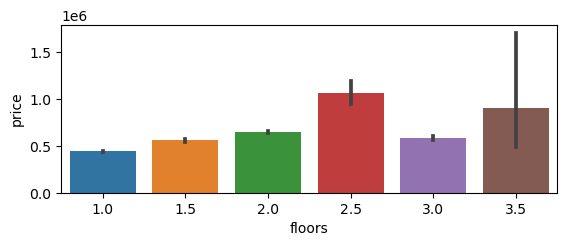

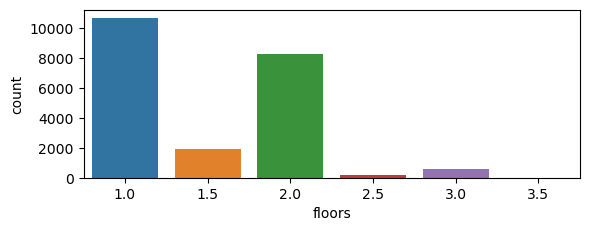

Column Name:  waterfront
0    21434
1      163
Name: waterfront, dtype: int64


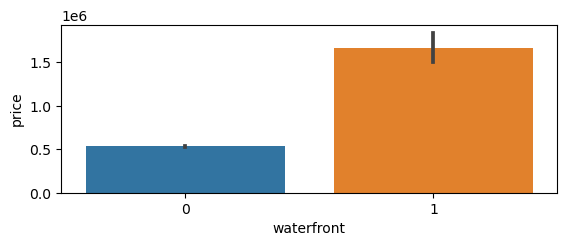

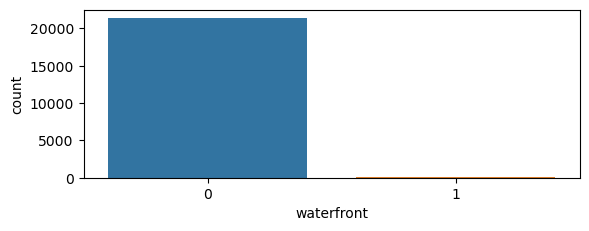

Column Name:  view
0    19475
2      961
3      510
1      332
4      319
Name: view, dtype: int64


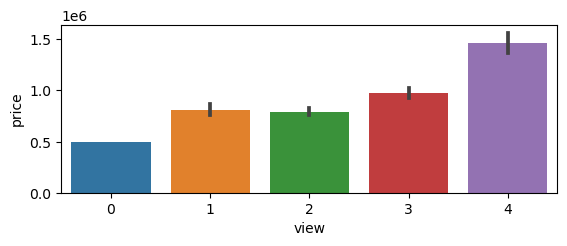

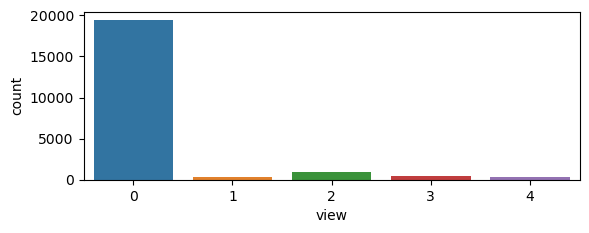

Column Name:  condition
3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64


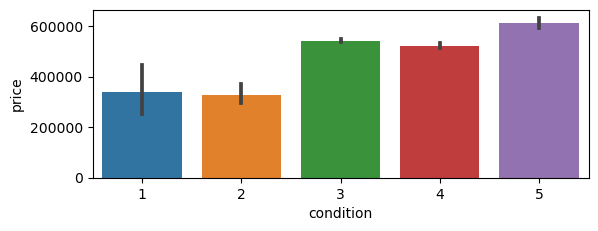

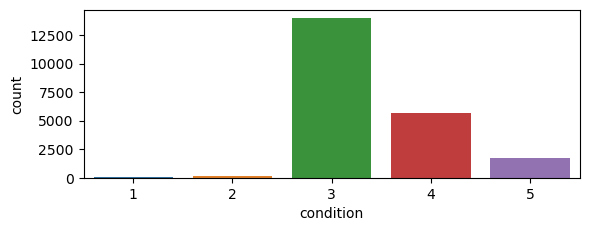

Column Name:  grade
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64


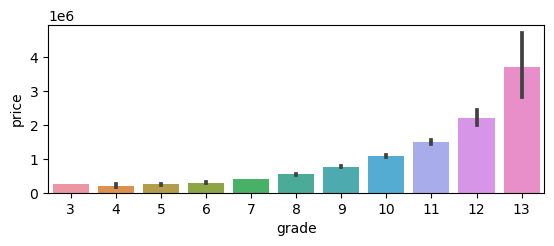

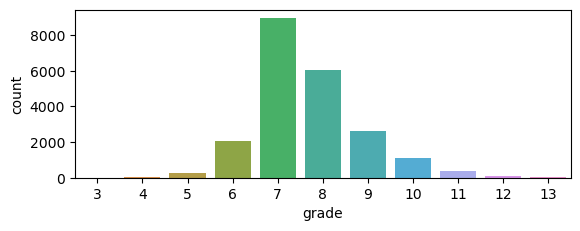

Column Name:  yr_built
2014    559
2006    453
2005    450
2004    433
2003    420
2007    417
1977    417
1978    387
1968    381
2008    367
1967    350
1979    343
1959    334
1990    317
1962    312
1954    305
2001    305
1987    294
1989    290
1969    280
1955    271
1988    270
1999    263
1947    263
1963    255
1976    253
1966    249
1994    249
1950    249
1960    248
1980    240
1998    239
1948    234
2009    230
1951    229
1984    229
1985    227
1961    224
1958    224
1991    224
1942    223
2002    222
1953    222
1952    220
2000    218
1986    215
1983    212
1993    202
2013    201
1981    199
1992    198
1957    198
1956    198
1949    195
1996    194
1975    189
1965    187
1926    180
1997    177
1964    172
2012    170
1943    170
1995    169
1925    165
1974    162
1941    161
1940    156
1972    149
1973    149
2010    143
1944    140
1924    139
1910    134
1970    132
2011    130
1928    126
1946    126
1918    120
1927    115
1929    114
1939    106
1982 

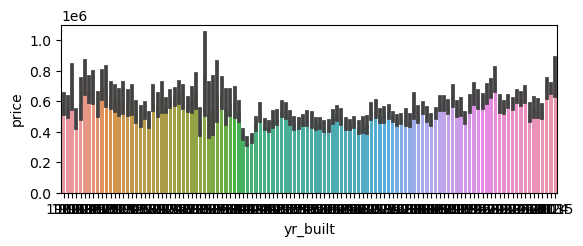

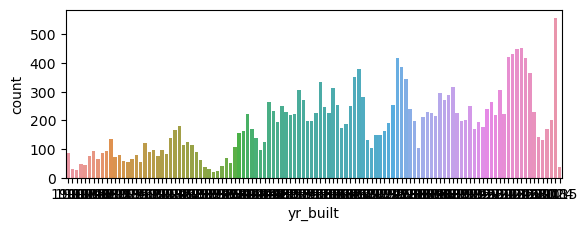

Column Name:  yr_renovated
0       20683
2014       91
2013       37
2003       36
2005       35
2007       35
2000       35
2004       26
1990       25
2006       24
2002       22
2009       22
1989       22
1991       20
1998       19
2001       19
1994       19
1993       19
1987       18
2010       18
2008       18
1983       18
1984       18
1985       17
1999       17
1992       17
1986       17
2015       16
1995       16
1988       15
1996       15
1997       15
2011       13
2012       11
1980       11
1982       11
1979       10
1970        9
1977        8
1968        8
1978        6
1975        6
1973        5
1965        5
1981        5
1964        5
1958        5
1960        4
1972        4
1963        4
1969        4
1976        3
1974        3
1953        3
1955        3
1956        3
1945        3
1957        3
1950        2
1962        2
1940        2
1946        2
1971        2
1967        2
1934        1
1951        1
1959        1
1948        1
1954        1
1944   

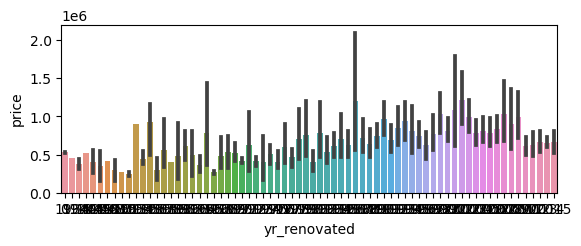

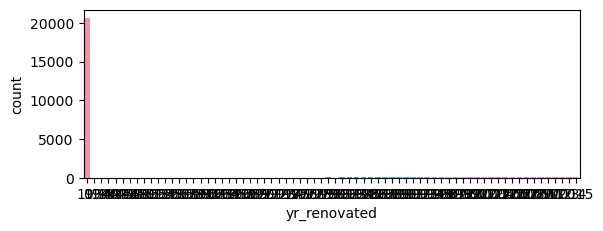

Column Name:  zipcode
98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
98006    498
98133    493
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    409
98056    406
98053    403
98001    361
98075    359
98126    354
98092    351
98144    343
98106    335
98116    330
98029    321
98004    317
98199    317
98065    308
98122    290
98146    288
98008    283
98028    283
98040    282
98198    280
98003    280
98031    273
98072    273
98168    269
98112    269
98055    268
98107    266
98136    263
98178    262
98030    256
98177    255
98166    254
98022    233
98105    229
98045    220
98002    199
98077    198
98011    195
98019    190
98108    186
98119    184
98005    168
98007    141
98188    136
98032    125
98014    124
98070    117
98109    109
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, dtype: int64


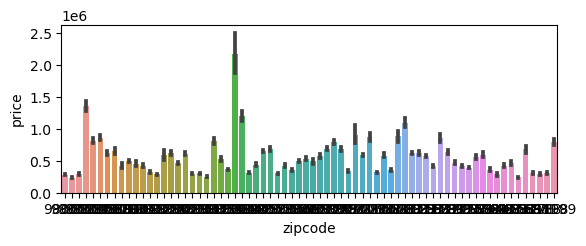

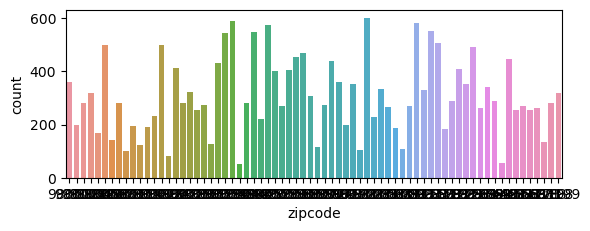

Column Name:  year_sold
2014    14622
2015     6975
Name: year_sold, dtype: int64


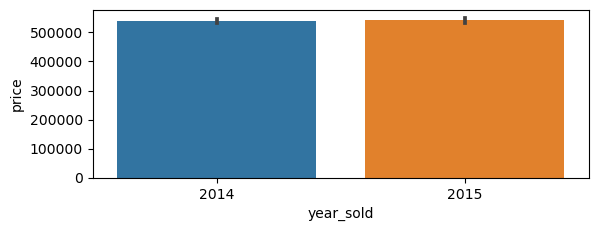

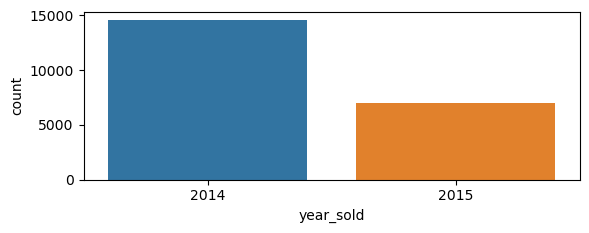

In [16]:
for col in categoricals.columns:
    print("Column Name: ",col)
    print(categoricals[col].value_counts())
    plt.subplot(2,1,1)
    sns.barplot(y=data['price'],x=col, data=categoricals)
    plt.show()
    plt.subplot(2,1,2)
    sns.countplot(x=col,data=categoricals)
    plt.show()

In [17]:
# yr.renovated to binary field
# list(map(lambda x: 1 if x > 0 else x, categoricals['yr_renovated']))
categoricals['renovated'] = list(map(lambda x: 1 if x > 0 else x, categoricals['yr_renovated']))

In [45]:
# categoricals = categoricals.drop(['yr_renovated'],axis=1)

In [ ]:
# extract "attic" from floor column

In [81]:
# list(map(lambda x: str(x).split('.')[1], categoricals['floors']))

In [46]:
categoricals['attic'] = list(map(lambda x: True if str(x).split('.')[1] == '5' else False, categoricals['floors']))

IndexError: list index out of range

In [19]:
# 0 = single-floor. 1 = multi-floor house
categoricals['floors'] = list(map(lambda x: "multi_floor" if pd.to_numeric(str(x).split('.')[0]) >= 2 else 'one_floor', categoricals['floors']))

In [80]:
# list(map(lambda x: 1 if pd.to_numeric(str(x).split('.')[0]) >= 2 else 0, categoricals['floors']))

In [129]:
# categoricals['bathrooms']

0        1.00
1        2.25
2        1.00
3        3.00
4        2.00
5        4.50
6        2.25
7        1.50
8        1.00
9        2.50
10       2.50
11       1.00
12       1.00
13       1.75
14       2.00
15       3.00
16       2.00
17       1.00
18       1.00
19       1.00
20       1.75
21       2.75
22       2.50
23       1.50
24       2.25
25       2.00
26       1.75
27       1.00
28       1.75
29       2.50
30       2.50
31       1.50
32       1.75
33       1.00
34       2.75
35       2.50
36       1.00
37       2.00
38       1.00
39       2.50
40       2.50
41       2.25
42       2.75
43       1.00
44       1.00
45       2.50
46       1.00
47       2.50
48       1.75
49       2.50
50       1.00
51       2.50
52       1.75
53       1.75
54       2.25
55       2.50
56       2.50
57       2.50
58       3.25
59       3.00
60       2.25
61       1.75
62       1.75
63       1.75
64       2.25
65       2.75
66       2.50
67       2.50
68       1.00
69       2.25
70       3.25
71    

In [93]:
# categoricals['bathrooms2'] = categoricals['bathrooms']

In [136]:
# def split_br_b (x):
#     var = int(str(x).split('.'))
#     if var[1] == 25:
#         return 1
#     elif var[1] == 5:
#         return 2
#     elif var[1] == 75:
#         return 3
#     else:
#         return 0

In [20]:
def split_br_b (x):
    var = pd.to_numeric(str(x).split('.'))
    if var[1] == 25:
        return 1
    elif var[1] == 5:
        return 2
    elif var[1] == 75:
        return 3
    else:
        return 0

In [21]:
def split_br_a (x):
    var = pd.to_numeric(str(x).split('.'))
    return var[0]

In [146]:
# int(str(categoricals['bathrooms'][5]).split('.')[1])

5

In [22]:
categoricals['part_br'] = list(map(split_br_b,categoricals['bathrooms']))

In [23]:
categoricals['bathrooms2'] = list(map(split_br_a,categoricals['bathrooms']))

In [24]:
categoricals.head(10)

bedrooms  bathrooms  floors  waterfront  view  condition  grade  yr_built  \
0         3       1.00       0           0     0          3      7      1955   
1         3       2.25       1           0     0          3      7      1951   
2         2       1.00       0           0     0          3      6      1933   
3         4       3.00       0           0     0          5      7      1965   
4         3       2.00       0           0     0          3      8      1987   
5         4       4.50       0           0     0          3     11      2001   
6         3       2.25       1           0     0          3      7      1995   
7         3       1.50       0           0     0          3      7      1963   
8         3       1.00       0           0     0          3      7      1960   
9         3       2.50       1           0     0          3      7      2003   

   yr_renovated  zipcode  year_sold  renovated  attic  part_br  bathrooms2  
0             0    98178       2014          0      0        0           1  
1          1991    98125       2014          1      0        1           2  
2             0    98028       2015          0      0        0           1  
3             0    98136       2014          0      0        0           3  
4             0    98074       2015          0      0        0           2  
5             0    98053       2014          0      0        2           4  
6             0    98003       2014          0      0        1           2  
7             0    98198       2015          0      0        2           1  
8             0    98146       2015          0      0        0           1  
9             0    98038       2015          0      0        2           2

In [25]:
categoricals['built_qcut'] = pd.qcut(categoricals['yr_built'],4, labels= ['1900-1951','1952-1975','1976-1997','1997-2015'])

In [26]:
categoricals['built_cut'] = pd.cut(categoricals['yr_built'],4, labels=['1900-1928','1929-1957', '1958-1986','1987-2015'])

In [27]:
pd.concat([categoricals['built_cut'].value_counts(),categoricals['built_qcut'].value_counts()], axis=1)

built_cut  built_qcut
1987-2015     7842.0         NaN
1958-1986     6928.0         NaN
1929-1957     4299.0         NaN
1900-1928     2528.0         NaN
1952-1975        NaN      5515.0
1900-1951        NaN      5413.0
1976-1997        NaN      5411.0
1997-2015        NaN      5258.0

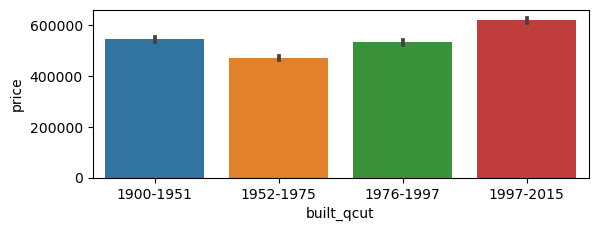

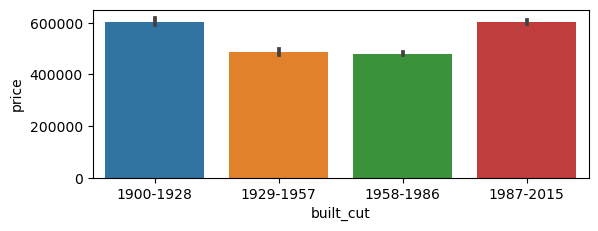

In [28]:
plt.subplot(2,1,1)
sns.barplot(y=data['price'],x=categoricals['built_qcut'], data=categoricals)
plt.show()
plt.subplot(2,1,2)
sns.barplot(y=data['price'],x=categoricals['built_cut'], data=categoricals)
plt.show()

In [29]:
categoricals = categoricals.drop(['built_cut'],axis=1)

In [31]:
categoricals['view'].value_counts()/len(categoricals)

0    0.901746
2    0.044497
3    0.023614
1    0.015373
4    0.014771
Name: view, dtype: float64

It is statiscally insignificant that the property is waterfront as 90%+ of all waterfront properties have a vew of 3 or greater

In [37]:
# categoricals['bedroom_test_a'] =list(map(lambda x: 0 if x <= 4 else 1, categoricals['bedrooms']))

In [41]:
categoricals['bedroom_test_b'] =list(map(lambda x: "1-3" if x <= 3 else '4+', categoricals['bedrooms']))

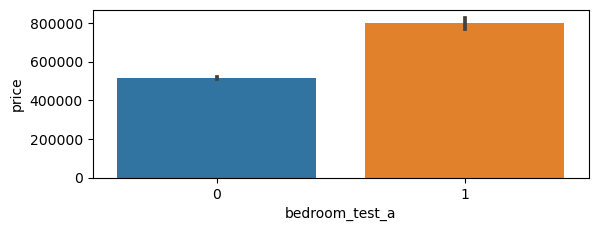

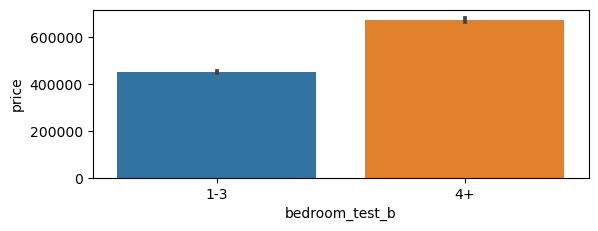

In [42]:
plt.subplot (2,1,1)
sns.barplot(x=categoricals['bedroom_test_a'], y=data['price'])
plt.show()
plt.subplot (2,1,2)
sns.barplot(x=categoricals['bedroom_test_b'], y=data['price'])
plt.show()

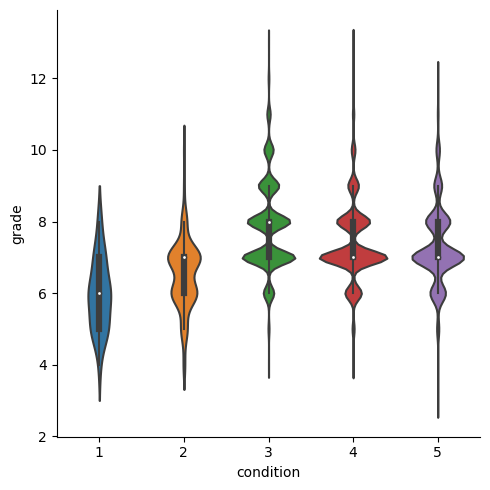

In [47]:
sns.catplot(data=categoricals, x="condition", y="grade", kind="violin")

In [60]:
# pd.concat([categoricals['grade'].value_counts(),categoricals['condition'].value_counts()], axis=1, sort=True)

In [66]:
categoricals['grade_new'] =list(map(lambda x: "1-7" if x <= 7 else '8+', categoricals['grade']))

<Axes: xlabel='grade_new', ylabel='price'>

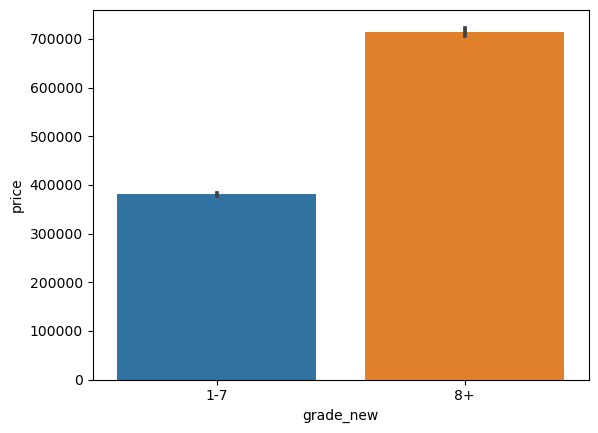

In [67]:
sns.barplot(x=categoricals['grade_new'],y=data['price'])

In [71]:
categoricals = categoricals.drop(['zipcode','bathrooms','yr_built','yr_renovated','waterfront', 'bedrooms', 'grade', 'bedroom_test_a'],axis=1)

In [72]:
categoricals.head()

floors  view  condition  year_sold  renovated  attic  part_br  bathrooms2  \
0       0     0          3       2014          0      0        0           1   
1       1     0          3       2014          1      0        1           2   
2       0     0          3       2015          0      0        0           1   
3       0     0          5       2014          0      0        0           3   
4       0     0          3       2015          0      0        0           2   

  built_qcut  bedroom_test bedroom_test_b grade_new  
0  1952-1975             0            1-3       1-7  
1  1900-1951             0            1-3       1-7  
2  1900-1951             0            1-3       1-7  
3  1952-1975             0             4+       1-7  
4  1976-1997             0            1-3        8+

In [73]:
numericals.head()

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0         1180      5650        1180              0           1340   
1         2570      7242        2170            400           1690   
2          770     10000         770              0           2720   
3         1960      5000        1050            910           1360   
4         1680      8080        1680              0           1800   

   sqft_lot15   price  
0        5650  221900  
1        7639  538000  
2        8062  180000  
3        5000  604000  
4        7503  510000

In [74]:
numericals.corr()

sqft_living  sqft_lot  sqft_above  sqft_basement  \
sqft_living       1.000000  0.173453    0.876448       0.435130   
sqft_lot          0.173453  1.000000    0.184139       0.015418   
sqft_above        0.876448  0.184139    1.000000      -0.052156   
sqft_basement     0.435130  0.015418   -0.052156       1.000000   
sqft_living15     0.756402  0.144763    0.731767       0.200443   
sqft_lot15        0.184342  0.718204    0.195077       0.017550   
price             0.701917  0.089876    0.605368       0.323799   

               sqft_living15  sqft_lot15     price  
sqft_living         0.756402    0.184342  0.701917  
sqft_lot            0.144763    0.718204  0.089876  
sqft_above          0.731767    0.195077  0.605368  
sqft_basement       0.200443    0.017550  0.323799  
sqft_living15       1.000000    0.183515  0.585241  
sqft_lot15          0.183515    1.000000  0.082845  
price               0.585241    0.082845  1.000000

<Axes: >

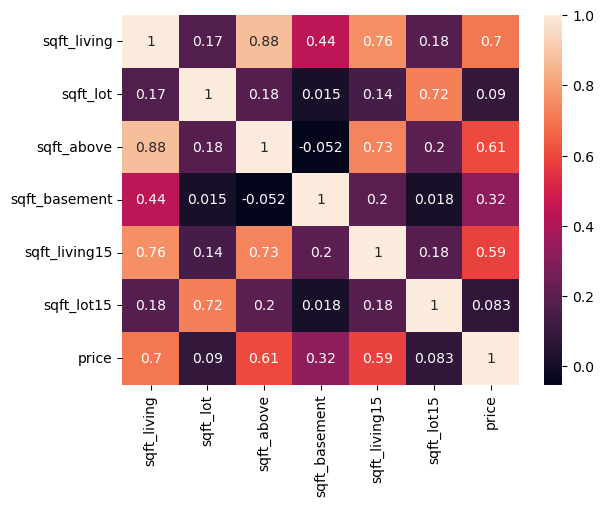

In [76]:
sns.heatmap(numericals.corr(), annot=True)

In [80]:
categoricals['has_basement'] = list(map(lambda x: 1 if x > 1 else 0, numericals['sqft_basement']))

In [81]:
numericals = numericals.drop(['sqft_basement'],axis=1)

In [84]:
numericals = numericals.drop(['sqft_living','sqft_lot'],axis=1)

In [87]:
numericals = numericals.drop(['sqft_above'],axis=1)

<Axes: >

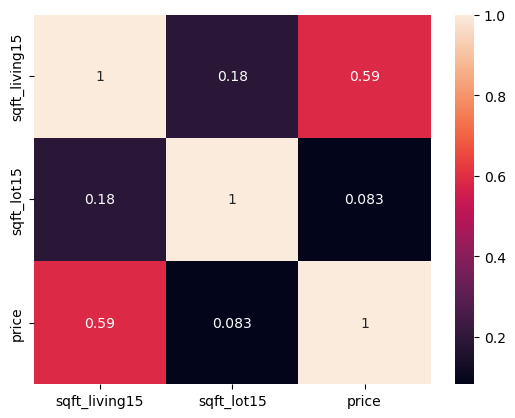

In [88]:
sns.heatmap(numericals.corr(), annot=True)

In [107]:
encoder = OneHotEncoder(drop='first')
encoded_cate = pd.DataFrame(encoder.fit_transform(categoricals).toarray())

In [108]:
encoded_cate.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0

In [111]:
numericals = numericals.drop(['price'],axis=1)
y = data['price']

In [115]:
mm_scal = MinMaxScaler()
scaled_num = pd.DataFrame(mm_scal.fit_transform(numericals))

In [116]:
scaled_num

0         1
0      0.161934  0.005742
1      0.222165  0.008027
2      0.399415  0.008513
3      0.165376  0.004996
4      0.241094  0.007871
5      0.750473  0.116339
6      0.316469  0.007085
7      0.215281  0.010407
8      0.237653  0.008572
9      0.342626  0.007948
10     0.311650  0.009504
11     0.160213  0.006144
12     0.237653  0.013837
13     0.167097  0.010978
14     0.165376  0.004823
15     0.299604  0.003847
16     0.256582  0.015355
17     0.208398  0.004192
18     0.113750  0.005105
19     0.151609  0.009418
20     0.172260  0.004973
21     0.638616  0.022612
22     0.316813  0.007299
23     0.141284  0.008885
24     0.309929  0.007138
25     0.108587  0.004657
26     0.234211  0.003357
27     0.251420  0.003687
28     0.192910  0.006414
29     0.383927  0.006174
30     0.375323  0.003824
31     0.170539  0.001269
32     0.182585  0.004996
33     0.201514  0.005088
34     0.278954  0.009269
35     0.204956  0.003002
36     0.303046  0.012424
37     0.229048  0.004651
38     0.153330  0.008212
39     0.382206  0.012903
40     0.356393  0.005764
41     0.346068  0.034422
42     0.555154  0.005730
43     0.203235  0.002285
44     0.161934  0.009370
45     0.456204  0.009857
46     0.142660  0.009407
47     0.392531  0.014972
48     0.098262  0.005111
49     0.392531  0.082548
50     0.136121  0.010009
51     0.273791  0.009743
52     0.173980  0.003939
53     0.186027  0.006992
54     0.401136  0.006144
55     0.266908  0.004996
56     0.318534  0.004421
57     0.394252  0.004709
58     0.440716  0.011938
59     0.321976  0.009064
60     0.373602  0.020963
61     0.153330  0.009303
62     0.361556  0.010165
63     0.203235  0.002802
64     0.179143  0.003939
65     0.179143  0.003847
66     0.404578  0.011944
67     0.313543  0.004487
68     0.105145  0.013766
69     0.514713  0.022408
70     0.538806  0.043956
71     0.213560  0.004703
72     0.191189  0.008220
73     0.347789  0.004996
74     0.265187  0.057295
75     0.488900  0.039480
76     0.220444  0.007867
77     0.084495  0.005065
78     0.125796  0.005792
79     0.507830  0.044913
80     0.335743  0.005413
81     0.253141  0.006610
82     0.227327  0.006971
83     0.249699  0.009357
84     0.201514  0.007526
85     0.278954  0.004766
86     0.204956  0.008631
87     0.258303  0.007694
88     0.266908  0.001578
89     0.108587  0.000523
90     0.272070  0.007879
91     0.364997  0.006432
92     0.163655  0.011314
93     0.201514  0.004421
94     0.201514  0.004421
95     0.266908  0.006196
96     0.232490  0.017190
97     0.130959  0.006604
98     0.215281  0.154368
99     0.370160  0.039531
100    0.309929  0.004421
101    0.208398  0.003247
102    0.373602  0.054134
103    0.339184  0.008572
104    0.213560  0.016379
105    0.318534  0.008628
106    0.144726  0.003853
107    0.149888  0.004957
108    0.445879  0.039458
109    0.361556  0.010088
110    0.265187  0.010321
111    0.168818  0.003314
112    0.196352  0.012641
113    0.291000  0.005570
114    0.385648  0.009036
115    0.246257  0.006546
116    0.210119  0.002889
117    0.136121  0.007040
118    0.254861  0.009590
119    0.208398  0.003893
120    0.334022  0.011722
121    0.203235  0.009710
122    0.225607  0.006144
123    0.249699  0.004306
124    0.395973  0.015325
125    0.457925  0.012204
126    0.389090  0.009260
127    0.291000  0.008901
128    0.223886  0.004950
129    0.270349  0.003558
130    0.175701  0.008074
131    0.285837  0.010501
132    0.358114  0.100912
133    0.222165  0.001161
134    0.196352  0.001877
135    0.198073  0.021382
136    0.232490  0.008603
137    0.198073  0.011240
138    0.113750  0.005817
139    0.163655  0.000757
140    0.132679  0.003388
141    0.416624  0.010021
142    0.208398  0.009107
143    0.199793  0.008373
144    0.315092  0.009388
145    0.420065  0.100327
146    0.309929  0.003847
147    0.265187  0.221919
148    0.165376  0.019929
149    0.180864  0.004535
150    0.189468  0.002802
151    0.175701  0.004996
152    0.220444  0.009169
153    0.4

In [117]:
features = pd.concat([scaled_num,encoded_cate],axis=1)

In [126]:
import math

In [123]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=10)

In [140]:
scores = []
complexity = []
for i in range(1,100, 5):
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(x_train, y_train)
    predictions_ = model.predict(x_test)
    scores.append(math.sqrt(mean_squared_error(y_test, predictions_)))
    complexity.append(np.log(1/i))

Text(0, 0.5, 'RMSE')

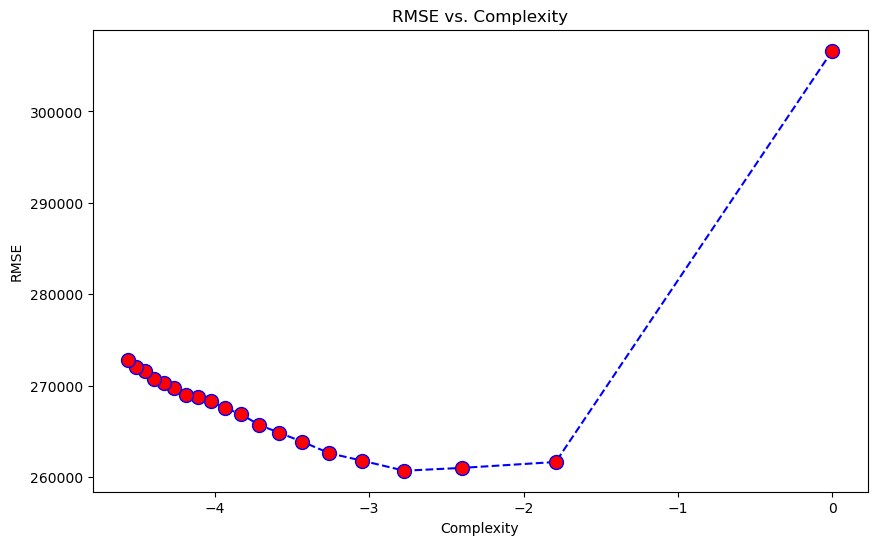

In [141]:
plt.figure(figsize=(10,6))
plt.plot(complexity,scores,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('RMSE vs. Complexity')
plt.xlabel('Complexity')
plt.ylabel('RMSE')

In [143]:
pd.DataFrame([range(1,100, 5),scores,complexity]).T

0              1         2
0    1.0  306647.195169  0.000000
1    6.0  261654.306003 -1.791759
2   11.0  261008.807175 -2.397895
3   16.0  260697.949208 -2.772589
4   21.0  261792.428384 -3.044522
5   26.0  262612.413365 -3.258097
6   31.0  263876.038812 -3.433987
7   36.0  264853.684530 -3.583519
8   41.0  265715.884985 -3.713572
9   46.0  266861.576779 -3.828641
10  51.0  267556.012883 -3.931826
11  56.0  268272.468348 -4.025352
12  61.0  268748.461482 -4.110874
13  66.0  269022.771175 -4.189655
14  71.0  269696.127957 -4.262680
15  76.0  270316.318367 -4.330733
16  81.0  270759.956892 -4.394449
17  86.0  271627.944447 -4.454347
18  91.0  272049.140264 -4.510860
19  96.0  272809.816686 -4.564348

In [145]:
lm_model = LinearRegression()
mlp_model = MLPRegressor()
knn_model = KNeighborsRegressor(n_neighbors=16)

In [146]:
model_list = [lm_model,knn_model,mlp_model]

In [152]:
def model_run(x,y,model):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    r2 = r2_score(y_test, predictions)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    return print(model,'\n',"R2 Score: ",r2,'\n', "RMSE Score: ",rmse,'\n', "MAE Score:", mae)

In [153]:
for i in model_list:
    model_run(features, y, i)

LinearRegression() 
 R2 Score:  0.5306151317182917 
 RMSE Score:  247020.60918617473 
 MAE Score: 152302.25725994818
KNeighborsRegressor(n_neighbors=16) 
 R2 Score:  0.47719716045243976 
 RMSE Score:  260697.94920828703 
 MAE Score: 151235.02320601852
MLPRegressor() 
 R2 Score:  -1.1150718458987083 
 RMSE Score:  524361.9961460525 
 MAE Score: 395991.11551560235


C:\Users\Gabriel Valdes\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
